# Libraries

In [4]:
# Library
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import os

# These will let us use R packages:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

# Convert pandas.DataFrames to R dataframes automatically.
pandas2ri.activate()

# R package
MDPtoolbox = importr("MDPtoolbox")


# Configurations

In [5]:
# CONFIGURATION
# Board size
board_size = 7

# Ship counts for each player
total_ships_player_one = 4
total_ships_player_two = 4

# Ship lengths by standard rules
ship_lengths = {"1": 2,
                "2": 3,
                "3": 3,
                "4": 5
               }


# Set ship lengths remaining for each ship 
ship_remaining_player_one = {"1": 2,
                             "2": 3,
                             "3": 3,
                             "4": 5
                            }
ship_remaining_player_two = {"1": 2,
                             "2": 3,
                             "3": 3,
                             "4": 5
                            }

# Gameplay Functions

In [6]:
# Function to switch player after each turn
def switch_player(player_track):
    if player_track == 1:
        player_track = 2
    elif player_track == 2:
        player_track = 1
    else:
        raise 'Error: Player Number is not 1 or 2'

In [7]:
# Human board set
def set_board_human(board):
    print(f'Ship location selection beginning. Human.')
    
    i=1 # Ship number
    while i <= total_ships_player_one :
        print(f"Selecting ship {i}. Size {ship_lengths[str(i)]}")
        # For human player, ask for input
        # Row
        try:
            row = int(input(f'Select starting row for ship {i}: '))-1
        except ValueError:
            print('non-numeric')
            continue
        # Col    
        try:
            col = int(input(f'Select starting column for ship {i}: '))-1
        except ValueError:
            print('non-numeric')
            continue
        # Direction
        try:
            direction = input(f'Select direction for ship {i}: ').lower()
        except ValueError:
            print('non-numeric')
            continue
        
        # Validate direction
        valid_direction = {'left','right','up','down'}
        if direction not in valid_direction:
            raise f'ValueError: choice must be one of {valid_direction}'
        
        # Set end point by direction choice
        direction_adjustment = {"left":col - ship_lengths[str(i)] + 1,
                                "right":col + ship_lengths[str(i)] - 1,
                                "up":row - ship_lengths[str(i)] + 1,
                                "down":row + ship_lengths[str(i)] - 1}
        
        # Check location is possible 
        if (col >= 7) or (row >= 7):
            print('Starting position Out of Range. Must be 1-7')
            continue
        elif isinstance(col, int) == False or isinstance(row, int) == False:
            print('Starting position Not Feasible. Must be integer 1-7')
            continue
        if (direction_adjustment[direction] >= 7) or (direction_adjustment[direction] < 0):
            print('Ending position Out of Range. Ship too large for start and direction.')
            print(direction_adjustment[direction])
            continue
        elif direction in ["left","right"]:
            out_col_start = min(col, direction_adjustment[direction])
            out_col_end = max(col,direction_adjustment[direction])
            
            if board.iloc[row, out_col_start:out_col_end+1].str.contains('ship').any():
                print('Ship in the area already. Please select a new one.')
                continue
            else:
                board.iloc[row, out_col_start:out_col_end+1] = f'ship {i}'
                i += 1
        elif direction in ["up","down"]:
            out_row_start = min(row, direction_adjustment[direction])
            out_row_end = max(row,direction_adjustment[direction])
            
            if board.iloc[out_row_start:out_row_end+1,col].str.contains('ship').any():
                print('Ship in the area already. Please select a new one.')
                continue
            else:
                board.iloc[out_row_start:out_row_end+1,col] = f'ship {i}'
                i += 1
            
        print(board)
        
       
    print('Player 1 Starting Board:')
    print(board)
    
    return board
    

In [8]:
# Random board set
def set_board_random(board, player_ships):
    print(f'Ship location selection beginning. Random.')    
    j = 1 # Ship number
    iterations = 0
    while j <= player_ships :
        iterations += 1
        # For human player, ask for input
        # Select random number from 0 to 7 and take floor to give position
        row = int(np.random.uniform(0,7))
        col = int(np.random.uniform(0,7))
        
        # Select random number 0 to 4 and take floor to give direction
        direction_num = int(np.random.uniform(0,4))
        direction_map = {0:"left",
                         1:"right",
                         2:"up",
                         3:"down"
                        }
        direction = direction_map[direction_num]
        
        # Set end point by direction choice
        direction_adjustment = {"left":col - ship_lengths[str(j)] + 1,
                                "right":col + ship_lengths[str(j)] - 1,
                                "up":row - ship_lengths[str(j)] + 1,
                                "down":row + ship_lengths[str(j)] - 1}
            
        if (col >= 7) or (row >= 7):
            continue
        elif direction_adjustment[direction] < 0 or direction_adjustment[direction] >= 7:
            continue
        elif direction in ["left","right"]:
            out_col_start = min(col, direction_adjustment[direction])
            out_col_end = max(col,direction_adjustment[direction])
            
            if board.iloc[row, out_col_start:out_col_end+1].str.contains('ship').any():
                continue
            else:
                board.iloc[row, out_col_start:out_col_end+1] = f'ship {j}'
                j += 1
        elif direction in ["up","down"]:
            out_row_start = min(row, direction_adjustment[direction])
            out_row_end = max(row,direction_adjustment[direction])
            
            if board.iloc[out_row_start:out_row_end+1,col].str.contains('ship').any():
                continue
            else:
                board.iloc[out_row_start:out_row_end+1,col] = f'ship {j}'
                j += 1
        
    print(f'Random Board output after {iterations} iterations')
    return board
    

In [9]:
# Function for human turn
def human_take_turn(move_board, opponent_board):  
    global total_ships_player_one
    global total_ships_player_two
    
    # Display previous moves
    print('MOVES ALREADY TAKEN: ')
    print(move_board)
    
    # Take turn and continue asking until valid move given
    valid_move_taken = 0
    while (valid_move_taken == 0):
        # Location to fire on
        try:
            frow = int(input('Row to Fire On: '))
        except ValueError:
            print('No numeric answer provided. Please resubmit.')
            continue
            
        try:
            fcol = int(input('Column to Fire On: '))
        except ValueError:
            print('No numeric answer provided. Please resubmit.')
            continue 
        
        # Check choice
        if frow > 7 or frow < 1:
            print('Invalid Row Number. Please choose 1 - 7')
            continue
        elif fcol >7 or fcol < 1:
            print('Invalid Column Number. Please choose 1 - 7')
            continue
                    
        # If hit, player two loses a ship   
        if ('ship' in str(opponent_board.iloc[frow-1,fcol-1])):
            # Decrease length of ship
            ship = str(opponent_board.iloc[frow-1,fcol-1])[-1]
            ship_remaining_player_two[ship] = ship_remaining_player_two[ship] - 1
            
            # Update moves
            move_board.iloc[frow-1,fcol-1] = 'Hit'
            
            # Update player 2 board
            opponent_board.iloc[frow-1,fcol-1] = 'Hit'
            
            # Output results
            if ship_remaining_player_two[ship] == 0:
                print(f'Battleship Hit! Sunk ship {ship}.')
                total_ships_player_two = total_ships_player_two-1
            else:
                print(f'Battleship Hit!')
        elif ('hit' in str(opponent_board.iloc[frow-1,fcol-1])):
            pass
            print('Hit ship already hit!')    
        else:
            move_board.iloc[frow-1,fcol-1] = 'Miss'
            print('Miss!')
        
        # If reach end, valid move was taken
        valid_move_taken = 1
        

In [10]:
# Function for random turn
def random_turn(opponent_board):  
    global total_ships_player_one
    global total_ships_player_two
    
    # Display previous moves
    #print('MOVES ALREADY TAKEN: ')
    #print(move_board)
    
    # Take turn and continue asking until valid move given
    valid_move_taken = 0
    while (valid_move_taken == 0):
        # Location to fire on
        frow = int(np.random.uniform(0,7))
        fcol = int(np.random.uniform(0,7))
                    
        if frow >= 7 or frow < 0 or fcol >=7 or fcol < 0:
            continue
                    
        # If hit, player two loses a ship   
        if ('ship' in str(opponent_board.iloc[frow-1,fcol-1])):
            # Decrease length of ship
            ship = str(opponent_board.iloc[frow-1,fcol-1])[-1]
            ship_remaining_player_two[ship] = ship_remaining_player_two[ship] - 1
            
            # Update player 2 board
            opponent_board.iloc[frow-1,fcol-1] = 'Hit'
            
            # Output results
            if ship_remaining_player_two[ship] == 0:
                print(f'Battleship Hit! Sunk ship {ship}.')
                total_ships_player_two = total_ships_player_two-1
            else:
                print(f'Battleship Hit!')
        elif ('hit' in str(opponent_board.iloc[frow-1,fcol-1])):
            print('Hit ship already hit!')    
        else:
            print('Miss!')
        
        # If reach end, valid move was taken
        valid_move_taken = 1
        

In [11]:
# Functions for MDP turn
def mdp_turn(move_board,opponent_board, last_move, last_outcome):
    global total_ships_player_one
    global total_ships_player_two
    global ship_lengths
    global ship_remaining_player_one
    
    #print("##### CURRENT MOVES #####")
    #print(move_board)
    #print("##### PLAYER 1 BOARD #####")
    #print(opponent_board)
    
    # Find out whether last move was a hit
    prev_move_status = move_board.iloc[last_move[0],last_move[1]]
    
    # Set states
    # States are equal to the total number of possible hits. 
    # The goal is to hit 15 hits, the sum of all ship sizes
    total_possible_hits = sum(ship_lengths.values())
    total_hits_left = sum(ship_remaining_player_one.values())
    total_hits_made = total_possible_hits - total_hits_left 
    S = np.arange(0,total_possible_hits+1)
    
    # Actions
    # Options: Move up, down, left, right from previous position or choose random
    A = [0,1,2,3,4]
    
    # Rewards
    # All same reward
    #R = np.ones((total_possible_hits+1,len(A)))
    # All same reward with extra for final
    R = np.ones((total_possible_hits+1,len(A)))
    #R[13, :] = 10
    R[total_possible_hits, :] = 10
    # Reward increases with more hits
    #R = np.ones((total_possible_hits+1,len(A)))
    #for k in range(total_possible_hits+1):
    #    R[k,:] = k
    # Only reward on final -- bad
    #R = np.zeros((total_possible_hits+1,len(A)))
    #R[total_possible_hits,:] = 1
    
    # Chosen actions
    action_choice = {0:[(last_move[0]-1)%7,last_move[1]], # Up
                     1:[(last_move[0]+1)%7,last_move[1]], # Down
                     2:[last_move[0],(last_move[1]-1)%7], # Left
                     3:[last_move[0],(last_move[1]+1)%7], # Right
                     4:choose_random_tile(move_board) # Random 
                     #TO DO: Actions of up to 4 up or down b/c can pick any square within the area
                    }
    
    # Setting probabilities
    # Calculate probability of going to next state, another hit, based on action
    # Initialize empty
    T = []
    
    # Set probabilities for each action and transition based on current board knowledge
    for i in range(len(action_choice)):
        # Initialize all 0
        action_trans_prob = np.zeros((total_possible_hits+1,total_possible_hits+1))
        
        for row in range(total_possible_hits): #range(13):
            # Case where next one is already known
            if pd.isna(move_board.iloc[action_choice[i][0],action_choice[i][1]]) == False:
                # If already have information on that spot, won't be a hit and will stay
                p = 0
                #action_trans_prob[row,row] = 1
            
            # Case where current action is unknown, but free tiles <= number left
            elif pd.isna(move_board.iloc[action_choice[i][0],action_choice[i][1]]) == True\
               and (move_board.isna().sum().sum() <= (total_possible_hits - row)): #(13-row)):
                # If on a unknown tile and total unknowns is same as total to determine, definite hit
                p = 1
            
            # Look at possible next spaces around hit
            elif last_outcome == 'hit':
                # Probability is 1/number of possible free locations around hit times # ships of length in game
                # /# ships in game
                # If opposite of action a hit and previous was a hit, the next in chain must be 
                if i == 0 or i == 2:
                    if move_board.iloc[action_choice[i+1][0],action_choice[i+1][1]] == 'hit':
                        p = .5
                    else:
                        # Must be single line. Will break if multiple.
                        non_null_neighbor = pd.isna(move_board.iloc[action_choice[0][0],action_choice[0][1]])+ pd.isna(move_board.iloc[action_choice[1][0],action_choice[1][1]])+pd.isna(move_board.iloc[action_choice[2][0],action_choice[2][1]])+pd.isna(move_board.iloc[action_choice[3][0],action_choice[3][1]])
                        if non_null_neighbor == 0:
                            p=0
                        else:
                            p = 1/non_null_neighbor
                    
                elif i == 1 or i == 3:
                    if move_board.iloc[action_choice[i-1][0],action_choice[i-1][1]] == 'hit':
                        p = .5
                    else:
                        # Must be single line. Will break if multiple.
                        non_null_neighbor = pd.isna(move_board.iloc[action_choice[0][0],action_choice[0][1]])+ pd.isna(move_board.iloc[action_choice[1][0],action_choice[1][1]])+pd.isna(move_board.iloc[action_choice[2][0],action_choice[2][1]])+pd.isna(move_board.iloc[action_choice[3][0],action_choice[3][1]])
                        if non_null_neighbor == 0:
                            p=0
                        else:
                            p = 1/non_null_neighbor
                
                # Else the probability is the number around hit that is unknown 
                # times number of ships of that size available out of total ships available
                else:
                    # Must be single line. Will break if multiple.
                    non_null_neighbor = pd.isna(move_board.iloc[action_choice[0][0],action_choice[0][1]])+ pd.isna(move_board.iloc[action_choice[1][0],action_choice[1][1]])+pd.isna(move_board.iloc[action_choice[2][0],action_choice[2][1]])+pd.isna(move_board.iloc[action_choice[3][0],action_choice[3][1]])
                    if non_null_neighbor == 0:
                            p=0
                    else:
                        p = 1/non_null_neighbor
                    
            # If last outcome was a miss and previous two were a hit, then definitely opposite
            # Set to standard probability if previous was a miss or sink. No info known
            else:
                # Set one off diagonals to p, the probability of a hit
                # Probability is uniform according to the board - number hits left in state out of total unknown spots
                total_spots_unknown = move_board.isna().sum().sum()
                if total_spots_unknown < (total_possible_hits - row):#(13-row):
                    p = 1
                else:
                    p = (total_possible_hits - row)/total_spots_unknown #(13-row)/total_spots_unknown # Total possible hits left out of total spots unknown
                
            # Set probability choice is not a hit
            q = 1-p
            
            # Set diagonals to q
            # These are all probabilities of staying in state, a miss
            action_trans_prob[row,row] = q
            
            # Set off diagonals to probability of moving to next state, a hit
            if row < (total_possible_hits):#13:
                action_trans_prob[row,row+1] = p
        
        # Set probability of staying in 13 hit as one, an absorbing state
        #action_trans_prob[13,13] = 1
        action_trans_prob[total_possible_hits,total_possible_hits]
        # Add probability for action to 
        T.append(action_trans_prob)

    # Check valid
    print(MDPtoolbox.mdp_check(T,R))
    
    # Run MDP - Q-learning
    battle_ship_mdp = MDPtoolbox.mdp_Q_learning(T,R,0.96)
    
    # Run MDP - value iteration
    #battle_ship_mdp = MDPtoolbox.mdp_value_iteration(T,R,0.2)
    
    # policy choice
    policy_choice = np.array(battle_ship_mdp.rx("policy"))[0][total_hits_made-1] - 1
    fire_choice = action_choice[policy_choice]
    
    # Take action choice
    frow = fire_choice[0]
    fcol = fire_choice[1]
    
    # If hit, player one loses a ship
    if ('ship' in str(opponent_board.iloc[frow-1,fcol-1])): 
        # Decrease length of ship
        ship = str(opponent_board.iloc[frow-1,fcol-1])[-1]
        ship_remaining_player_one[ship] = ship_remaining_player_one[ship] - 1
        
        # Update moves
        move_board.iloc[frow-1,fcol-1] = 'Hit'
        
        # Update player one board
        opponent_board.iloc[frow-1,fcol-1] = 'Hit'
        
        # Output results
        if ship_remaining_player_one[ship] == 0:
            print(f'Battleship Hit! Sunk ship {ship}.')
            total_ships_player_one = total_ships_player_one-1
            outcome = 'sink'
        else:
            outcome = 'hit'
            print('Battleship Hit!')
    elif ('Hit' in str(opponent_board.iloc[frow-1,fcol-1])):
        outcome = 're-hit'
        print('Hit ship already hit!')
    else:
        move_board.iloc[frow-1,fcol-1] = 'Miss'
        outcome = 'miss'
        print('Miss!')
    
    # Return location fired on
    return policy_choice, fire_choice, outcome

# Chooses random tile in MDP
def choose_random_tile(moves_taken):
    valid_move = 0
    while valid_move == 0:
        frow = int(np.random.uniform(0,7))
        fcol = int(np.random.uniform(0,7))
           
        if pd.isna(moves_taken.iloc[frow,fcol]) == False:
            continue
        else:
            choice = [frow,fcol]
            valid_move = 1
       
    return choice


In [12]:
# Prevents printing in simulation
# Disable
def blockPrint():
    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, 'w')
    return old_stdout

# Restore
def enablePrint(old_stdout):
    sys.stdout = old_stdout # reset old stdout
    
#old_stdout = sys.stdout # backup current stdout
#sys.stdout = open(os.devnull, "w")


In [13]:
# Function to run battleship game
def play_battleship(simulation = False):
    global total_ships_player_one
    global total_ships_player_two

    # Set players
    if simulation == True:
        player_one = "random"
        print_location = blockPrint()
    else:
        player_one = input('Is the player human or random? ').lower()

    if player_one not in ['human','random']:
        raise 'ValueError: choice must be one of human or random'
    
    player_two = "mdp"
        
    # Board for each player
    board_player_1 = pd.DataFrame(index=range(board_size),
                                  columns=range(board_size)
                                 )
    board_player_2 = pd.DataFrame(index=range(board_size),
                                  columns=range(board_size)
                                 )
    
    # Set positions of ships
    # Player one
    if player_one == "human":
        board_player_1 = set_board_human(board_player_1)
    else:
        board_player_1 = set_board_random(board_player_1, total_ships_player_one)
    
    # Player two
    board_player_2 = set_board_random(board_player_2, total_ships_player_two)
 
    
    # Set tracking board for moves and decisions
    moves_player_1 = pd.DataFrame(index=range(board_size),
                                  columns=range(board_size)
                                 )
    moves_player_2 = pd.DataFrame(index=range(board_size),
                                  columns=range(board_size)
                                 )
    mdp_decisions = []
    
    # Begin gameplay
    current_player = 1 # track current player
    turn = 1 # track turn
    while (total_ships_player_one > 0)and (total_ships_player_two > 0):
        print(f'##### PLAYER {current_player} TAKING TURN {turn} #####')
        
        # Take appropriate turn by current_player
        if (current_player == 1) and (player_one == "human"):
            print('CURRENT STATUS OF HUMAN BOARD: ')
            print(board_player_1)
            human_take_turn(move_board = moves_player_1, 
                            opponent_board = board_player_2)    
        elif (current_player == 1) and (player_one == "random"):
            random_turn(opponent_board = board_player_2)
        
        # MDP turn
        elif (current_player == 2):
            # First turn for MDP run random choice
            if turn == 1:
                # Take random guess for first one
                frow = int(np.random.uniform(0,7))
                fcol = int(np.random.uniform(0,7))
                
                # Track guess
                mdp_move = [frow,fcol]
                
                # If hit, player two loses a ship   
                if ('ship' in str(board_player_1.iloc[frow-1,fcol-1])):
                    # Decrease length of ship
                    ship = str(board_player_1.iloc[frow-1,fcol-1])[-1]
                    ship_remaining_player_one[ship] = ship_remaining_player_one[ship] - 1
                    
                    # Update moves
                    moves_player_2.iloc[frow-1,fcol-1] = 'Hit'
                    
                    # Update player 2 board
                    board_player_1.iloc[frow-1,fcol-1] = 'Hit'
                    
                    # Output results
                    # Note, can't sink on turn 1
                    mdp_outcome = 'hit'
                    print(f'Battleship Hit!')
                    
                else:
                    moves_player_2.iloc[frow-1,fcol-1] = 'Miss'
                    mdp_outcome = 'miss'
                    print('Miss!')
            
            # Subsequent turns, run MDP
            else:
                mdp_choice, mdp_move, mdp_outcome = mdp_turn(move_board = moves_player_2,
                                                             opponent_board = board_player_1, 
                                                             last_move = mdp_move, 
                                                             last_outcome = mdp_outcome)
                mdp_decisions.append(mdp_choice)
                print(f'Player 2 chose {mdp_choice}, fire {mdp_move}')
                
            turn += 1
        else:
            print(f'Issue with player {current_player}')
            break
        
        # Display current game progress
        if simulation == False:
            print('##### CURRENT STATUS #####')
            print(f'Player One has {total_ships_player_one} ships remaining with {sum(ship_remaining_player_one.values())} hits left') 
            print(f'Player Two has {total_ships_player_two} ships remaining with {sum(ship_remaining_player_two.values())} hits left')
            
        # Change player
        #switch_player(current_player)
        if current_player == 1:
            current_player = 2
        elif current_player == 2:
            current_player = 1
        else:
            raise 'Error: Player Number is not 1 or 2'
    
    # Used for simulation result 
    mdp_result = 0
    
    # Turn print back on
    if simulation == True:
        enablePrint(print_location)
        
    if total_ships_player_one == 0:
        print('#####################')
        print('##### GAME OVER #####')
        print('#####################')
        print('Player 2 wins! The Markov Decision Process has bested you.')
        mdp_result = 1
    elif total_ships_player_two == 0:
        print('#####################')
        print('##### GAME OVER #####')
        print('#####################')
        print(f'Player 1 wins! The {player_one} has beaten the Markov Decision Process.')
    
    return mdp_result, mdp_decisions


# Running Code

In [ ]:
# all same
# Ship counts for each player
total_ships_player_one = 4
total_ships_player_two = 4

# Ship lengths by standard rules
ship_lengths = {"1": 2,
                "2": 3,
                "3": 3,
                "4": 5
               }

# Set ship lengths remaining for each ship 
ship_remaining_player_one = {"1": 2,
                             "2": 3,
                             "3": 3,
                             "4": 5
                            }
ship_remaining_player_two = {"1": 2,
                             "2": 3,
                             "3": 3,
                             "4": 5
                            }
play_battleship()

In [40]:
## Evaluating performance
# Run simulations with normal config
num_sim = 40
results_normal = []
path_normal = []
for i in range(num_sim):
    print(f"RUNNING SIMULATION {i}")
    # Ship counts for each player
    total_ships_player_one = 4
    total_ships_player_two = 4

    # Ship lengths by standard rules
    ship_lengths = {"1": 2,
                    "2": 3,
                    "3": 3,
                    "4": 5
                   }


    # Set ship lengths remaining for each ship 
    ship_remaining_player_one = {"1": 2,
                                 "2": 3,
                                 "3": 3,
                                 "4": 5
                                }
    ship_remaining_player_two = {"1": 2,
                                 "2": 3,
                                 "3": 3,
                                 "4": 5
                                }
        
    win_normal, decisions_normal = play_battleship(simulation = True) 
    results_normal.append(win_normal)
    path_normal.append(decisions_normal)

print(results_normal)


RUNNING SIMULATION 0
#####################
##### GAME OVER #####
#####################
Player 2 wins! The Markov Decision Process has bested you.
RUNNING SIMULATION 1
#####################
##### GAME OVER #####
#####################
Player 1 wins! The random has beaten the Markov Decision Process.
RUNNING SIMULATION 2
#####################
##### GAME OVER #####
#####################
Player 2 wins! The Markov Decision Process has bested you.
RUNNING SIMULATION 3
#####################
##### GAME OVER #####
#####################
Player 1 wins! The random has beaten the Markov Decision Process.
RUNNING SIMULATION 4
#####################
##### GAME OVER #####
#####################
Player 1 wins! The random has beaten the Markov Decision Process.
RUNNING SIMULATION 5
#####################
##### GAME OVER #####
#####################
Player 1 wins! The random has beaten the Markov Decision Process.
RUNNING SIMULATION 6
#####################
##### GAME OVER #####
#####################
Player 2 

In [41]:
## Evaluating performance
# Run simulations with all 3's
results_all_3 = []
path_all_3 = []
for i in range(num_sim):
    print(f"RUNNING SIMULATION {i}")
    # Ship counts for each player
    total_ships_player_one = 4
    total_ships_player_two = 4

    # Ship lengths by standard rules
    ship_lengths = {"1": 3,
                    "2": 3,
                    "3": 3,
                    "4": 3
                   }

    # Set ship lengths remaining for each ship 
    ship_remaining_player_one = {"1": 3,
                                 "2": 3,
                                 "3": 3,
                                 "4": 3
                                }
    ship_remaining_player_two = {"1": 3,
                                 "2": 3,
                                 "3": 3,
                                 "4": 3
                                }
    
    win_all_3, decisions_all_3 = play_battleship(simulation = True) 
    results_all_3.append(win_all_3)
    path_all_3.append(decisions_all_3)

print(results_all_3)


RUNNING SIMULATION 0
#####################
##### GAME OVER #####
#####################
Player 2 wins! The Markov Decision Process has bested you.
RUNNING SIMULATION 1
#####################
##### GAME OVER #####
#####################
Player 2 wins! The Markov Decision Process has bested you.
RUNNING SIMULATION 2
#####################
##### GAME OVER #####
#####################
Player 2 wins! The Markov Decision Process has bested you.
RUNNING SIMULATION 3
#####################
##### GAME OVER #####
#####################
Player 1 wins! The random has beaten the Markov Decision Process.
RUNNING SIMULATION 4
#####################
##### GAME OVER #####
#####################
Player 1 wins! The random has beaten the Markov Decision Process.
RUNNING SIMULATION 5
#####################
##### GAME OVER #####
#####################
Player 2 wins! The Markov Decision Process has bested you.
RUNNING SIMULATION 6
#####################
##### GAME OVER #####
#####################
Player 1 wins! The rand

# Performance Evaluation

In [42]:
# Bootstrap function
# Resamples from 
def boot(data, B):
    win_perc_est = []
    win_count_est = []
    
    for i in range(B):
        # Sample with replacement
        boot_sample = random.choices(data, k = len(data))
        
        # Compute percentage win
        perc = sum(boot_sample)/len(boot_sample)
        
        # Average wins 
        count = sum(boot_sample)
        
        # Append results
        win_perc_est.append(perc)
        win_count_est.append(count)
    
    return win_perc_est, win_count_est

In [43]:
# Run bootstrap on wins
num_boot = 500
est_perc_distr_all_3, est_count_distr_all_3 = boot(results_all_3, num_boot)
est_perc_distr_normal, est_count_distr_normal = boot(results_normal, num_boot)

# Output Stats
print("Average Estimated Win Percentage: ", np.mean(est_perc_distr_all_3))
print("Variance of Estimate: ", np.var(est_perc_distr_all_3))
print("")
print("Average Estimated Win Count: ", np.mean(est_count_distr_all_3))
print("Variance of Estimate: ", np.var(est_count_distr_all_3))
print("")
print("Average Estimated Win Percentage Normal: ", np.mean(est_perc_distr_normal))
print("Variance of Estimate: ", np.var(est_perc_distr_normal))
print("")
print("Average Estimated Win Count Normal: ", np.mean(est_count_distr_normal))
print("Variance of Estimate: ", np.var(est_count_distr_normal))


Average Estimated Win Percentage:  0.475
Variance of Estimate:  0.006395

Average Estimated Win Count:  19.0
Variance of Estimate:  10.232

Average Estimated Win Percentage Normal:  0.27804999999999996
Variance of Estimate:  0.005156947499999999

Average Estimated Win Count Normal:  11.122
Variance of Estimate:  8.251115999999998


### Visuals

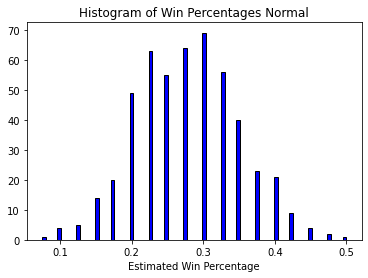

In [44]:
# Plot Distribution of Win Percentage
plt.hist(est_perc_distr_normal, color = 'blue', edgecolor = 'black',
         bins = 80)


# Add labels
plt.title('Histogram of Win Percentages Normal')
plt.xlabel('Estimated Win Percentage')
plt.ylabel('')

plt.show()

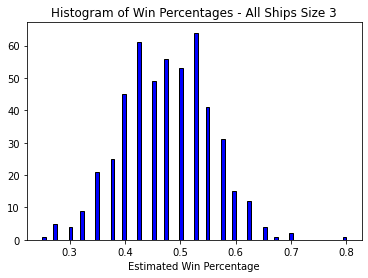

In [45]:
# Plot Distribution of Win Percentage Size 3 Ships
plt.hist(est_perc_distr_all_3, color = 'blue', edgecolor = 'black',
         bins = 80)


# Add labels
plt.title('Histogram of Win Percentages - All Ships Size 3')
plt.xlabel('Estimated Win Percentage')
plt.ylabel('')

plt.show()

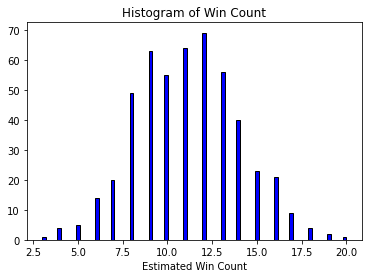

In [46]:
# Plot Distribution of Win Count Normal
plt.hist(est_count_distr_normal, color = 'blue', edgecolor = 'black',
         bins = 80)


# Add labels
plt.title('Histogram of Win Count')
plt.xlabel('Estimated Win Count')
plt.ylabel('')

plt.show()

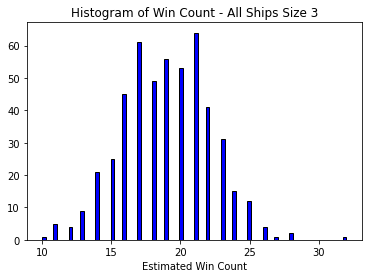

In [47]:
# Plot Distribution of Win Count Size 3 Ships
plt.hist(est_count_distr_all_3, color = 'blue', edgecolor = 'black',
         bins = 80)


# Add labels
plt.title('Histogram of Win Count - All Ships Size 3')
plt.xlabel('Estimated Win Count')
plt.ylabel('')

plt.show()

In [ ]:
# Show distribution of decisions

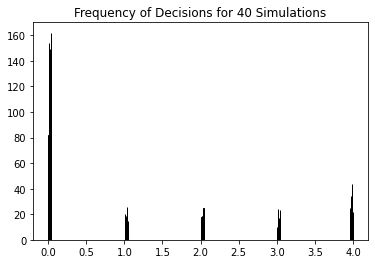

In [51]:
plt.title(f"Frequency of Decisions for {num_sim} Simulations")
plt.hist(path_normal, color = ['blue']*num_sim, edgecolor = 'black',
         bins = 80)
plt.show()

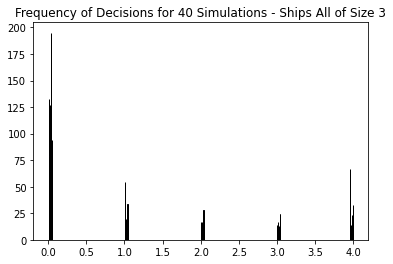

In [48]:
plt.title(f"Frequency of Decisions for {num_sim} Simulations - Ships All of Size 3")
plt.hist(path_all_3, color = ['blue']*num_sim, edgecolor = 'black',
         bins = 80)
plt.show()

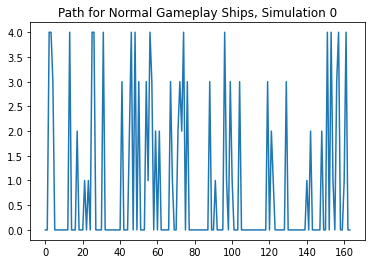

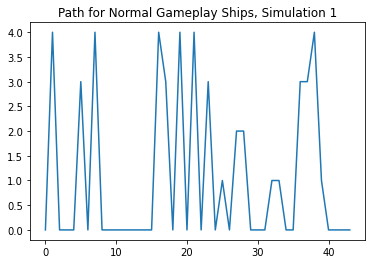

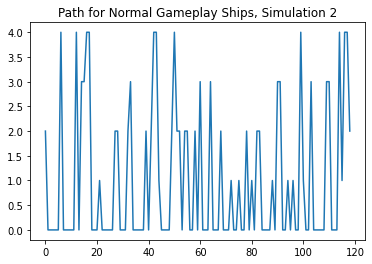

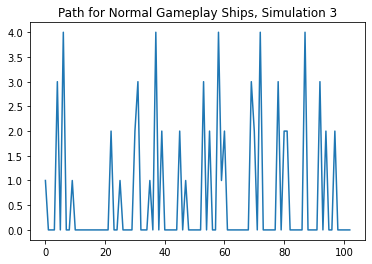

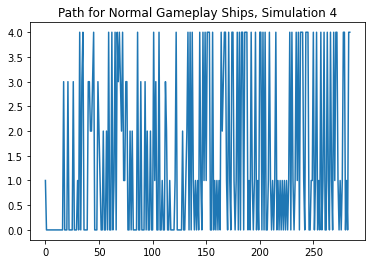

In [49]:
# Path of each
for p in range(len(path_all_3)):
    if p < 5:
        plt.title(f"Path for Normal Gameplay Ships, Simulation {p}")
        plt.plot(path_all_3[p])
        plt.show()
    else:
        break

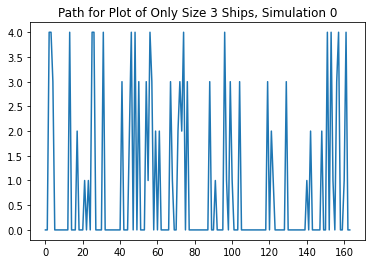

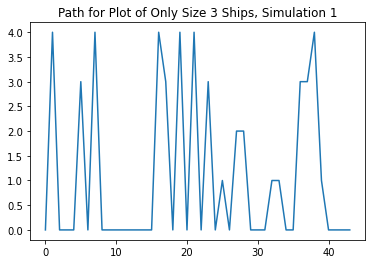

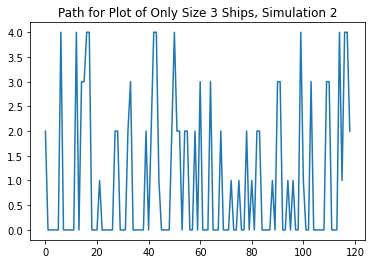

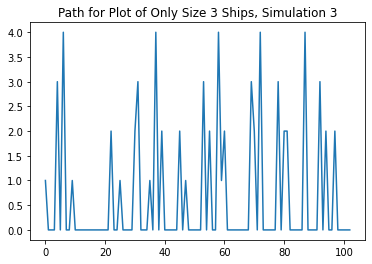

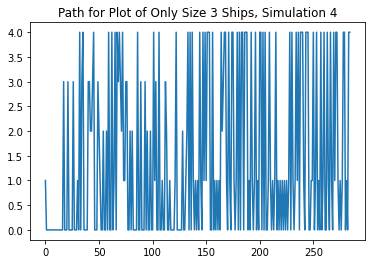

In [50]:
# Path of each
for p in range(len(path_all_3)):
    if p < 5:
        plt.title(f"Path for Plot of Only Size 3 Ships, Simulation {p}")
        plt.plot(path_all_3[p])
        plt.show()
    else:
        break